# Dashboard to look at impact tracker results for various experiment sets

## Datasets
- ukb pilot [cohort](https://github.com/neurodatascience/watts_up_compute/blob/impact_tracker/subject_lists/ukb_pilot_subjects.csv)

## Pipelines
- FreeSurfer: recon-all (1,2,3 stages)
- FastSurfer: FastSurferCNN (volumetric segmentation)

## Monitoring metrics
- experiment duration in hours
- power consumption in kWh (kilo-watt-hours) 

In [1]:
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../experiment-impact-tracker/')

from experiment_impact_tracker.data_interface import DataInterface
from experiment_impact_tracker.data_utils import *
from experiment_impact_tracker.data_utils import (load_data_into_frame,
                                                  load_initial_info,
                                                  zip_data_and_info)

from lib.dashboard_utils import *

loading region bounding boxes for computing carbon emissions region, this may take a moment...
 454/454... rate=396.77 Hz, eta=0:00:00, total=0:00:01, wall=17:39 EST
Done!


In [19]:
project_dir = '../'
fastsurfer_exp_dir = '{}/FastSurfer_experiments/'.format(project_dir)
preproc_exp_dir = '{}/preproc_pipeline_experiments/'.format(project_dir)
fastsurfer_results_dir = '{}results/exp_impact_tracker/'.format(fastsurfer_exp_dir)
preproc_results_dir = '{}results/exp_impact_tracker/'.format(preproc_exp_dir)
subject_lists = '{}subject_lists/ukb_pilot_subjects.csv'.format(project_dir)

### Custom set of trial expeirments

In [47]:
experiment_dict = {
                   'FastSurfer_local_cpu':('{}/track_sub_000_benchmark/'.format(fastsurfer_results_dir),False), 
                   'FastSurfer_CC_cpu':('{}/CC_cpu_test/'.format(fastsurfer_results_dir),False),
                   'FastSurfer_CC_gpu':('{}/CC_gpu_test/'.format(fastsurfer_results_dir),True),
                   'autorecon1_local_test_1':('{}/ReconAll_test_local_cpu/'.format(preproc_results_dir),False),
                   'autorecon2-3_local_test_1':('{}/ReconAll_test_location_override/'.format(preproc_results_dir),False),
                   'autorecon1_CC_test_1':('{}/ReconAll_test_CC_cpu/'.format(preproc_results_dir),False),
                   'autorecon1_CC_ukb_1':('{}/ReconAll_ukb_CC_cpu/'.format(preproc_results_dir),False)
                   }

read_flops = True

power_df_concat = pd.DataFrame()
flops_df_concat = pd.DataFrame()
tracker_summary_df_concat = pd.DataFrame()

for k,v in experiment_dict.items():
    power_df, flops_df, tracker_summary_df = get_tracker_data(k, v[0], v[1], read_flops)
    power_df_concat = power_df_concat.append(power_df)
    flops_df_concat = flops_df_concat.append(flops_df)
    tracker_summary_df_concat = tracker_summary_df_concat.append(tracker_summary_df)
    


number of timestamps: 2633
total_power sanity check: default: 0.06703, calculated: 0.06703, 0.06703
number of timestamps: 940
total_power sanity check: default: 0.13523, calculated: 0.13523, 0.13523
number of timestamps: 8
total_power sanity check: default: 0.00225, calculated: 0.00225, 0.00225
number of timestamps: 240
total_power sanity check: default: 0.00445, calculated: 0.00445, 0.00445
number of timestamps: 6808
total_power sanity check: default: 0.08423, calculated: 0.08423, 0.08423
number of timestamps: 332
total_power sanity check: default: 0.00381, calculated: 0.00381, 0.00381
number of timestamps: 239
total_power sanity check: default: 0.02303, calculated: 0.02303, 0.02303


In [50]:
exp_set = 'trial_runs'
cpu_info_df = pd.DataFrame(columns=['experiment_set','experiment_name','brand','usable_cpus'])
i = 0
for exp_name,exp_config in experiment_dict.items():
    tracker_log_dir = exp_config[0] 
    info = load_initial_info(tracker_log_dir)
    usable_cpus = info['cpu_info']['usable_cpus']
    brand = info['cpu_info']['brand_raw']
    cpu_info_df.loc[i] = [exp_set,exp_name,brand,usable_cpus]
    i = i + 1
    
cpu_info_df

In [51]:
cpu_info_df

,experiment_set,experiment_name,brand,usable_cpus
0,fastsurfer_cpu_prune_50,FastSurfer_local_cpu,Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz,8
1,fastsurfer_cpu_prune_50,FastSurfer_CC_cpu,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8
2,fastsurfer_cpu_prune_50,FastSurfer_CC_gpu,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,16
3,fastsurfer_cpu_prune_50,autorecon1_local_test_1,Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz,8
4,fastsurfer_cpu_prune_50,autorecon2-3_local_test_1,Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz,8
5,fastsurfer_cpu_prune_50,autorecon1_CC_test_1,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,1
6,fastsurfer_cpu_prune_50,autorecon1_CC_ukb_1,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,1


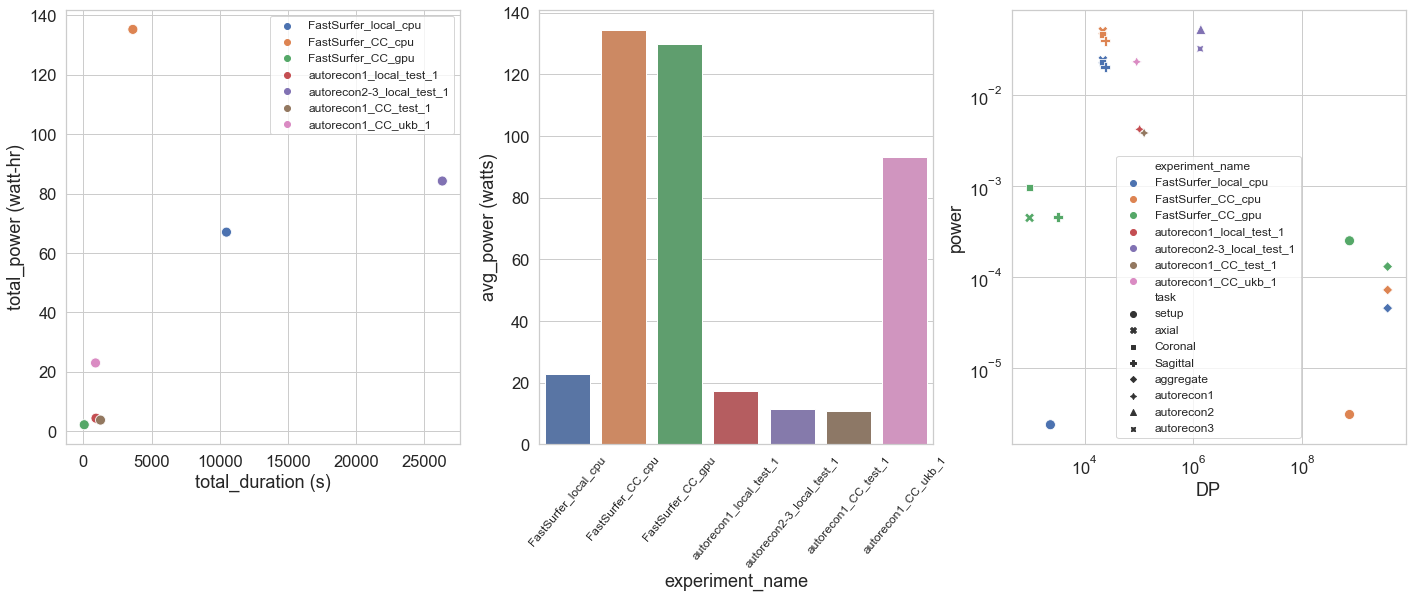

In [12]:
plot_df = tracker_summary_df_concat.copy()
plot_df['total_duration (s)'] = plot_df['total_duration_impact_tracker'] * 3600
plot_df['total_power (watt-hr)'] = plot_df['total_power'] * 1000
plot_df['avg_power (watts)'] = 1000 * plot_df['total_power'] / plot_df['total_duration_impact_tracker'] 

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1,3, figsize=(24,8),sharex=False,sharey=False)
    ax = axes[0]
    g = sns.scatterplot(y='total_power (watt-hr)', x='total_duration (s)', hue='experiment_name', s=100, data=plot_df, ax=ax)
    # g.set(xscale='log',yscale='log') 
    g.legend(fontsize=12)

    ax = axes[1]
    g = sns.barplot(y='avg_power (watts)', x='experiment_name', data=plot_df, ax=ax)
    g.set_xticklabels(g.get_xticklabels(),rotation=50,fontsize=12)

    ax = axes[2]
    plot_df = flops_df_concat.copy()
    g = sns.scatterplot(y='power', x='DP', hue='experiment_name', style='task', s=100, data=plot_df, ax=ax)
    g.set(xscale='log',yscale='log') 
    g.legend(fontsize=12)

### UKB pilot experiment sets
- recon-all 
- fastsurfer
    - pruning_{0,25,50}
    - gpu/cpu

In [20]:
save_perf = False

subject_df = pd.read_csv(subject_lists)
subject_ids = subject_df['eid']

ignore_subjects = {1009760}
subject_ids = list(set(subject_ids) - ignore_subjects)

print('Found {} subjects'.format(len(subject_ids)))

experiment_sets = {
                #    'recon-all':(preproc_results_dir + 'ukb/', False), # log_dir, use_cuda
                #    'fastsurfer_gpu_prune_0':(fastsurfer_results_dir + 'ukb/gpu/prune_0/', True), # log_dir, use_cuda
                #    'fastsurfer_gpu_prune_0_replicate':(fastsurfer_results_dir + 'ukb/gpu/prune_0_replicate/', True), # log_dir, use_cuda
                
                #    'fastsurfer_cpu_prune_0':(fastsurfer_results_dir + 'ukb/cpu/prune_0/', False), # log_dir, use_cuda
                #    'fastsurfer_cpu_prune_25':(fastsurfer_results_dir + 'ukb/cpu/prune_25/', False), # log_dir, use_cuda
                   'fastsurfer_cpu_prune_50':(fastsurfer_results_dir + 'ukb/cpu/prune_50/', False), # log_dir, use_cuda

                  }

for exp_set, exp_config in experiment_sets.items(): 
    tracker_log_dir = exp_config[0]
    use_cuda = exp_config[1]
    tracker_summary_df_concat, flops_df_concat, power_df_concat = collate_tracker_data(tracker_log_dir, subject_ids, use_cuda)
    tracker_summary_df_concat['experiment_set'] = exp_set
    flops_df_concat['experiment_set'] = exp_set
    power_df_concat['experiment_set'] = exp_set
    
    if save_perf:
        tracker_summary_df_concat.to_csv('{}{}'.format(tracker_log_dir,'tracker_summary_df_concat.csv'))
        flops_df_concat.to_csv('{}{}'.format(tracker_log_dir,'flops_df_concat.csv'))
        power_df_concat.to_csv('{}{}'.format(tracker_log_dir,'power_df_concat.csv'))


Found 72 subjects
number of timestamps: 407
number of timestamps: 296
total_power sanity check: default: 0.02590, calculated: 0.02590, 0.02590
total_power sanity check: default: 0.02457, calculated: 0.02457, 0.02457
number of timestamps: 381
total_power sanity check: default: 0.02132, calculated: 0.02132, 0.02132
number of timestamps: 302
total_power sanity check: default: 0.02528, calculated: 0.02528, 0.02528
number of timestamps: 304
total_power sanity check: default: 0.02614, calculated: 0.02614, 0.02614
number of timestamps: 379
total_power sanity check: default: 0.02192, calculated: 0.02192, 0.02192
number of timestamps: 410
total_power sanity check: default: 0.01959, calculated: 0.01959, 0.01959
number of timestamps: 407
total_power sanity check: default: 0.02066, calculated: 0.02066, 0.02066
number of timestamps: 297
total_power sanity check: default: 0.02472, calculated: 0.02472, 0.02472
number of timestamps: 295
number of timestamps: 361
total_power sanity check: default: 0.02

### Collate saved tracker perf

In [53]:
tracker_summary_df_concat_exp_set = pd.DataFrame()
flops_df_concat_exp_set = pd.DataFrame()
power_df_concat_exp_set = pd.DataFrame()

experiment_sets = {
                   'recon-all':(preproc_results_dir + 'ukb/', False), # log_dir, use_cuda
                   'fastsurfer_gpu_prune_0':(fastsurfer_results_dir + 'ukb/gpu/prune_0/', True), # log_dir, use_cuda
                   'fastsurfer_gpu_prune_0_replicate':(fastsurfer_results_dir + 'ukb/gpu/prune_0_replicate/', True), # log_dir, use_cuda
                   'fastsurfer_cpu_prune_0':(fastsurfer_results_dir + 'ukb/cpu/prune_0/', False), # log_dir, use_cuda
                #    'fastsurfer_cpu_prune_25':(fastsurfer_results_dir + 'ukb/cpu/prune_25/', False), # log_dir, use_cuda
                   'fastsurfer_cpu_prune_50':(fastsurfer_results_dir + 'ukb/cpu/prune_50/', False) # log_dir, use_cuda
                  }

for exp_set, exp_config in experiment_sets.items(): 
    tracker_log_dir = exp_config[0]
    tracker_summary_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'tracker_summary_df_concat.csv'))
    flops_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'flops_df_concat.csv'))
    power_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'power_df_concat.csv'))

    tracker_summary_df_concat_exp_set = tracker_summary_df_concat_exp_set.append(tracker_summary_df_concat)
    flops_df_concat_exp_set = flops_df_concat_exp_set.append(flops_df_concat)
    power_df_concat_exp_set = power_df_concat_exp_set.append(power_df_concat)


### Grab CPU/GPU info from the tracker logs

In [54]:
exp_names = tracker_summary_df_concat['experiment_name'].values

cpu_info_df = pd.DataFrame(columns=['experiment_set','experiment_name','brand','usable_cpus'])

i = 0
for exp_set, exp_config in experiment_sets.items(): 
    for exp_name in exp_names:
        tracker_log_dir = exp_config[0] + '/sub-{}'.format(int(exp_name))
        info = load_initial_info(tracker_log_dir)
        usable_cpus = info['cpu_info']['usable_cpus']
        brand = info['cpu_info']['brand_raw']
        cpu_info_df.loc[i] = [exp_set,exp_name,brand,usable_cpus]
        i = i + 1

# example run info across experiment sets
cpu_info_df[cpu_info_df['experiment_name']==1047553]

,experiment_set,experiment_name,brand,usable_cpus
0,recon-all,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,1
72,fastsurfer_gpu_prune_0,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,16
144,fastsurfer_gpu_prune_0_replicate,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,16
216,fastsurfer_cpu_prune_0,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8
288,fastsurfer_cpu_prune_50,1047553.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8


## Plots
### Duration

### Total power usage per experiment (i.e. subject)

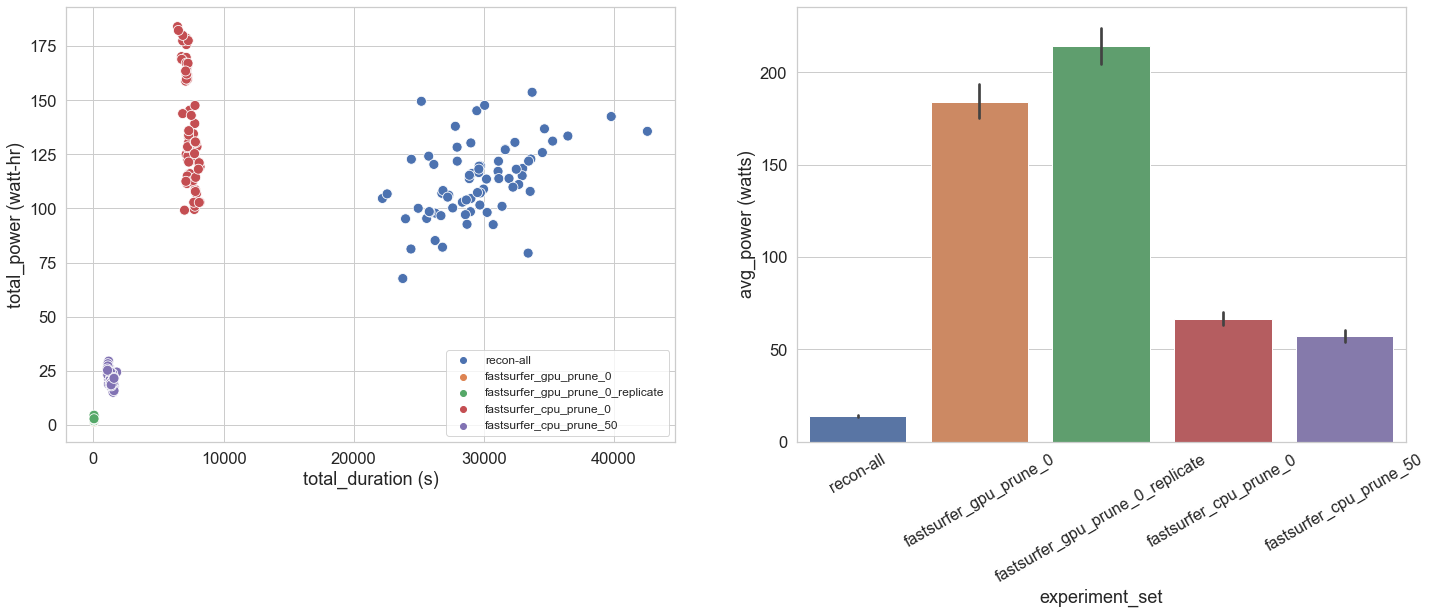

In [9]:
plot_df = tracker_summary_df_concat_exp_set.copy()
plot_df['total_duration (s)'] = plot_df['total_duration_impact_tracker'] * 3600
plot_df['total_power (watt-hr)'] = plot_df['total_power'] * 1000
plot_df['avg_power (watts)'] = 1000 * plot_df['total_power'] / plot_df['total_duration_impact_tracker'] 

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1,2, figsize=(24,8),sharex=False,sharey=False)
    ax = axes[0]
    g = sns.scatterplot(y='total_power (watt-hr)', x='total_duration (s)', hue='experiment_set', s=100, data=plot_df, ax=ax)
    # g = sns.barplot(y='total_power (watt-hr)', x='experiment_set',  data=plot_df, ax=ax)
    # g.set(xscale='log') 
    g.legend(fontsize=12)

    ax = axes[1]
    g = sns.barplot(y='avg_power (watts)', x='experiment_set', data=plot_df, ax=ax)
    g.set_xticklabels(g.get_xticklabels(),rotation=30,fontsize=16)
    # g.set(yscale='log') 



### Power for segmentation

2026 1954
434


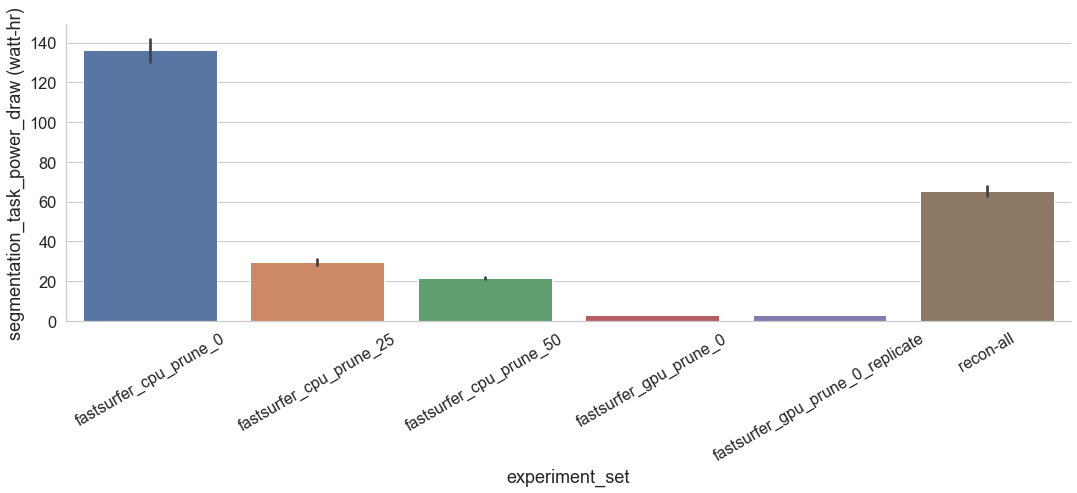

In [38]:
flops_df_concat_exp_set_segmentation = flops_df_concat_exp_set.copy()
flops_df_concat_exp_set_segmentation = flops_df_concat_exp_set_segmentation[~flops_df_concat_exp_set_segmentation['task'].isin(['autorecon3'])]
print(len(flops_df_concat_exp_set),len(flops_df_concat_exp_set_segmentation))
flops_df_concat_exp_set_segmentation = flops_df_concat_exp_set_segmentation.groupby(['experiment_name','experiment_set']).sum().reset_index()
print(len(flops_df_concat_exp_set_segmentation))
plot_df = flops_df_concat_exp_set_segmentation.copy()
plot_df['segmentation_task_power_draw (watt-hr)'] = plot_df['power']*1000

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='segmentation_task_power_draw (watt-hr)', x='experiment_set', data=plot_df, kind='bar',aspect=3)
    # g.set(yscale='log')
    g.set_xticklabels(rotation=30,fontsize=16)



### avg power reading

In [ ]:
plot_df = power_df_concat_exp_set.copy()

sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='total_power_per_timestep', x='experiment_name', hue='experiment_set', data=plot_df, kind='point',aspect=3)
    g.set_xticklabels(rotation=50,fontsize=12)


### Flops vs Power

In [57]:
plot_df

,Unnamed: 0,Unnamed: 0.1,task,start_time,duration,DP,experiment_name,power,experiment_set,MAC,params
0,0,0,autorecon1,0.000000,1193.583060,118191,1047553,0.004399,recon-all,NaN,NaN
1,1,1,autorecon2,1193.593848,17246.796646,1613383,1047553,0.074148,recon-all,NaN,NaN
2,2,2,autorecon3,18440.401663,16216.533094,1549612,1047553,0.058230,recon-all,NaN,NaN
3,0,0,autorecon1,0.000000,1532.785360,146042,3553027,0.003289,recon-all,NaN,NaN
4,1,1,autorecon2,1532.796368,17081.526851,1582919,3553027,0.041600,recon-all,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
355,0,0,setup,0.000000,2.560030,665908973,1474044,0.000002,fastsurfer_cpu_prune_50,0.0,0.0
356,1,1,axial,2.565180,162.292588,22755,1474044,0.002125,fastsurfer_cpu_prune_50,0.0,0.0
357,2,2,Coronal,164.862344,1236.514436,22768,1474044,0.017234,fastsurfer_cpu_prune_50,0.0,0.0
358,3,3,Sagittal,1401.381787,165.375981,25059,1474044,0.002130,fastsurfer_cpu_prune_50,0.0,0.0


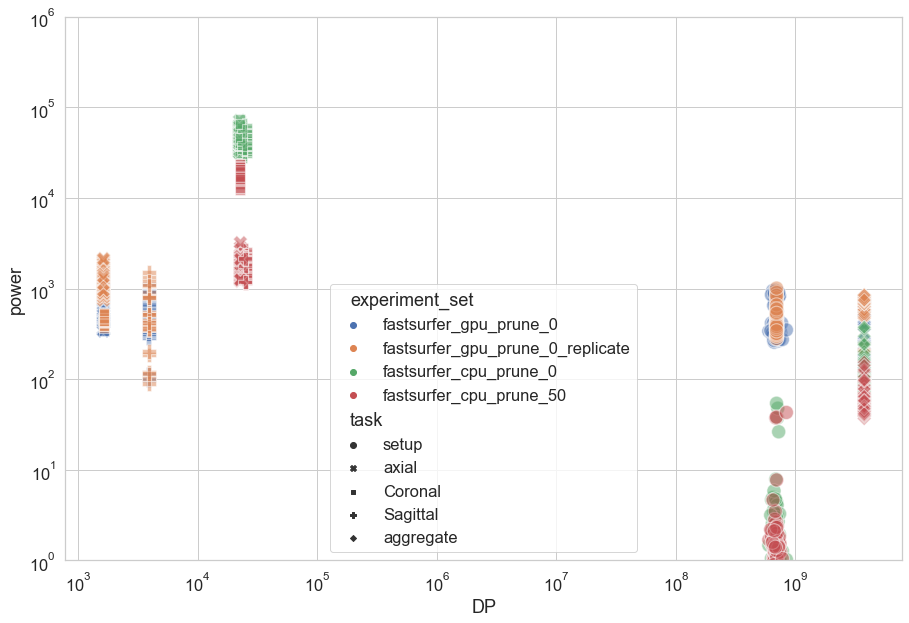

In [70]:
plot_df = flops_df_concat_exp_set.copy()
plot_df = plot_df[~(plot_df['experiment_set']=='recon-all')]
plot_df['power'] = plot_df['power']*1000000
sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,10),sharex=False,sharey=False)
    g = sns.scatterplot(y='power', x='DP', hue='experiment_set', alpha=0.5, style='task', s=200, data=plot_df)
    # g = sns.scatterplot(y='power', x='DP', hue='task', s=100, data=plot_df)
    g.set(xscale='log',yscale='log',ylim=[1, 1000000]) 


### Power trace

In [ ]:
experiment_set =  'recon-all' #'recon-all' #'fastsurfer_gpu_prune_0'
experiment_name = 1474044
use_cuda = True
plot_epochs = False

plot_df = power_df_concat_exp_set[(power_df_concat_exp_set['experiment_set']==experiment_set) & (power_df_concat_exp_set['experiment_name']==experiment_name)].copy()
total_power = tracker_summary_df_concat_exp_set[(tracker_summary_df_concat_exp_set['experiment_set']==experiment_set) & (tracker_summary_df_concat_exp_set['experiment_name']==experiment_name)]['total_power'].values[0]
PUE = tracker_summary_df_concat_exp_set[(tracker_summary_df_concat_exp_set['experiment_set']==experiment_set) & (tracker_summary_df_concat_exp_set['experiment_name']==experiment_name)]['PUE'].values[0]

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,5),sharex=False,sharey=False)

    g = sns.lineplot(plot_df['timestamp'],plot_df['total_power_per_timestep'].cumsum(),label='total attributed_power')

    if plot_epochs: 
        for e in epochs:
            g = plt.axvline(e, linestyle='-',c='purple')
        
    g = plt.axhline(total_power, linestyle='--',c='black',label='total power estimate')
    
    plt.ylabel('power_draws')
    plt.legend()
